## Optimising latent space dynamics for computational efficiency

Chemical kinetics

\begin{equation}
\frac{\text{d}z_{i}}{\text{d}t} \ = \ A_{ij} z_{j}+B_{ijk}z_jz_k
\end{equation}

In [1]:
import torch
import torchode          as to
import numpy             as np
import matplotlib.pyplot as plt

from tqdm   import tqdm
from time   import time


In [141]:
def g(t, z, args):
    A, B = args
    return torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z)


def make_args(n_latent):
    A  = torch.randn(n_latent, n_latent)
    B  = torch.randn(n_latent, n_latent, n_latent)

    return A,B

def make_setup(z0, n_batch, n_latent):

    # Initial conditions
    t0 = 0.0

    # End time and time step
    t1 = 1.e0
    dt = 1.0e-2
    t_eval = torch.arange(t0, t1, step=dt)

    t_eval_batch    = torch.empty(n_batch, t_eval.shape[0])
    z0_batch        = torch.empty(n_batch,     z0.shape[0])

    t_eval_batch[:] = t_eval
    z0_batch        = torch.rand(n_batch,n_latent) *2-1

    return t_eval_batch, z0_batch


def solver(z0, args, atol, rtol, n_batch, n_latent,DEVICE):
    t_eval,z_0 = make_setup(z0, n_batch, n_latent)

    odeterm = to.ODETerm(g, with_args=True)
    step_method          = to.Dopri5(term=odeterm)
    step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=odeterm)
    adjoint              = to.AutoDiffAdjoint(step_method, step_size_controller).to(DEVICE) # type: ignore

    jit_solver = torch.compile(adjoint)

    problem = to.InitialValueProblem(
        y0     = z_0,  ## "view" is om met de batches om te gaan
        t_eval = t_eval,
    )

    solution = jit_solver.solve(problem, args=args)

    return t_eval,solution.ys.data


# Setup solver
def solve(z0, args, f, atol, rtol, n_batch):
    start = time()

    t_eval,t_eval_batch, z0_batch = make_setup(z0, n_batch)

    
    term                 = to.ODETerm(f, with_args=True)
    step_method          = to.Dopri5(term=term)
    step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=term)
    # step_size_controller = to.PIDController(atol=atol, rtol=rtol, pcoeff=0.2, icoeff=0.5, dcoeff=0.0, term=term)
    solver               = to.AutoDiffAdjoint(step_method, step_size_controller)

    # Compile solver\
    jit_solver = torch.compile(solver)

    t_eval_batch    = torch.empty(n_batch, t_eval.shape[0])
    z0_batch        = torch.empty(n_batch,     z0.shape[0])

    t_eval_batch[:] = t_eval
    z0_batch    [:] = z0


    # Setup initial value problem\n",
    problem = to.InitialValueProblem(y0=z0_batch, t_eval=t_eval_batch)

    # Run solver
    wct =- time()
    solution = jit_solver.solve(problem, args=args)
    wct += time()

    print("elapsed time:", wct)
    print("success?     ", torch.all(solution.status == 0).item())

    return solution.ys[0].data

In [183]:
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

n_latent = 10
n_batch  = 10000

atol = 1.0e-5
rtol = 1.0e-2

args = make_args(n_latent)

z0 = torch.rand(n_latent)*2-1

t,sol = solver(z0, args, atol, rtol, n_batch, n_latent, DEVICE)


In [214]:
test=sol
print(test.shape)

w = np.where(np.logical_or(np.abs(sol) >10,np.isnan(sol)))

        

torch.Size([10000, 100, 10])


In [221]:
w

(array([   0,    0,    0, ..., 9999, 9999, 9999]),
 array([31, 32, 32, ..., 99, 99, 99]),
 array([9, 2, 9, ..., 7, 8, 9]))

In [217]:
idx = [0]
for i in range(1,len(w[0])):
    if w[0][i] != w[0][i-1]:
        idx.append(i)
print(len(idx),idx)
print(sol.shape)

9964 [0, 101, 265, 434, 453, 620, 633, 719, 747, 782, 887, 1116, 1129, 1163, 1181, 1200, 1205, 1228, 1253, 1274, 1284, 1395, 1435, 1522, 1637, 1656, 1673, 1706, 1869, 1892, 1909, 2130, 2292, 2311, 2334, 2362, 2376, 2393, 2404, 2495, 2524, 2544, 2642, 2744, 2771, 2783, 2809, 3026, 3068, 3458, 3572, 3975, 4308, 4695, 5089, 5393, 5434, 5440, 5455, 5484, 5515, 5537, 5701, 5728, 5753, 5831, 5850, 6016, 6025, 6033, 6170, 6188, 6314, 6389, 6475, 6492, 6520, 6740, 6913, 6981, 7010, 7030, 7049, 7067, 7091, 7109, 7120, 7135, 7210, 7231, 7384, 7548, 7560, 7603, 7653, 7782, 7951, 8176, 8255, 8272, 8298, 8323, 8330, 8349, 8358, 8367, 8378, 8398, 8416, 8562, 8732, 8743, 8913, 8929, 9158, 9287, 9333, 9368, 9383, 9406, 9441, 9462, 9478, 9504, 9526, 9553, 9565, 9594, 9748, 9915, 10048, 10155, 10164, 10192, 10334, 10488, 10515, 10631, 10666, 10679, 10825, 10941, 10954, 10968, 10994, 11117, 11141, 11195, 11255, 11297, 11459, 11622, 11730, 11760, 11814, 11837, 11863, 11874, 11987, 12165, 12176, 12195, 122

torch.Size([10000, 100]) torch.Size([10000, 100, 10])


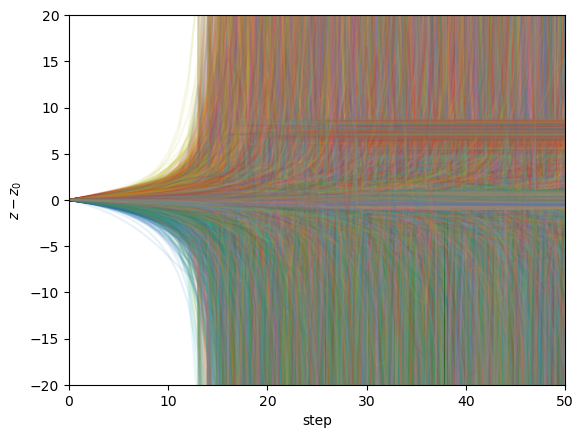

In [184]:
print(t.shape,sol.shape)

for i in range(sol.shape[0]):
    plt.plot(sol[i][:30]-sol[i][0], '-', alpha = 0.1)

plt.ylabel('$z-z_0$')
plt.xlabel('step')

plt.ylim([-20,20])
plt.xlim([0,50])

# plt.yscale('log')

plt.show()

torch.Size([10000, 100]) torch.Size([10000, 100, 10])


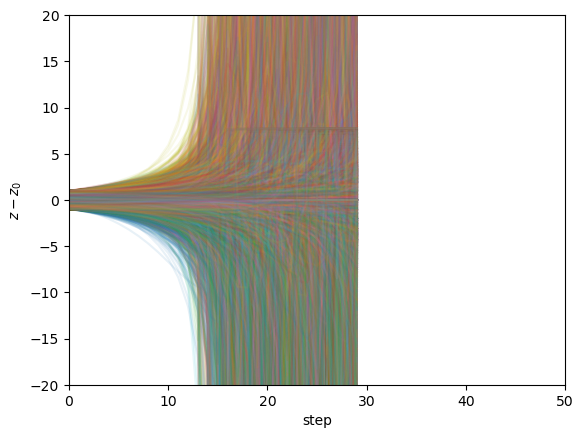

In [203]:
print(t.shape,sol.shape)

for i in range(sol.shape[0]):
    plt.plot(sol[i][:30], '-', alpha = 0.1)

plt.ylabel('$z-z_0$')
plt.xlabel('step')

plt.ylim([-20,20])
plt.xlim([0,50])

# plt.yscale('log')

plt.show()

### with NNs

In [5]:
class LatentODE(torch.nn.Module):
    
    def __init__(self, n_latent):
        
        super().__init__()
        
        self.n_latent = n_latent

        self.lin_1 = torch.nn.Linear(n_latent, n_latent)
        self.lin_2 = torch.nn.Linear(n_latent, n_latent)
        self.lin_3 = torch.nn.Linear(n_latent, n_latent)
        
        self.relu = torch.nn.LeakyReLU(0.2)
        self.sigm = torch.nn.Sigmoid()
        
    def forward(self, t, z):
        
        result = self.relu(self.lin_1(z))
        result = self.relu(self.lin_2(result))
        result = self.sigm(self.lin_3(result))
        
        return result
    
g = LatentODE(n_latent)

elapsed time: 0.017088890075683594
success?      True


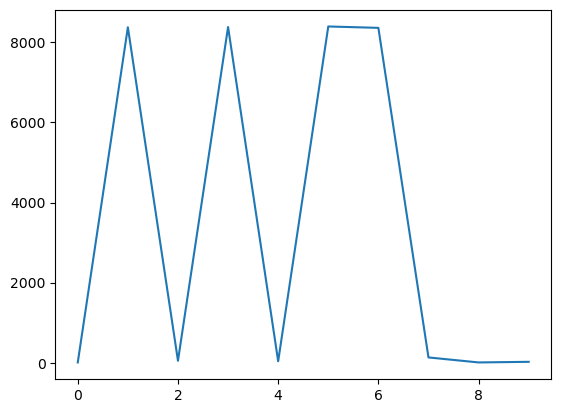

In [ ]:
# Setup solver
term                 = to.ODETerm(g.forward)#, with_args=True)
step_method          = to.Dopri5(term=term)
step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=term)
# step_size_controller = to.PIDController(atol=atol, rtol=rtol, pcoeff=0.2, icoeff=0.5, dcoeff=0.0, term=term)
solver               = to.AutoDiffAdjoint(step_method, step_size_controller)

# Compile solver\n",
jit_solver = torch.compile(solver)


# Setup initial value problem\n",
problem = to.InitialValueProblem(y0=z0_batch, t_eval=t_eval_batch)

# Run solver\n",
wct =- time()
solution = jit_solver.solve(problem, args=args)
# solution =     solver.solve(problem)#, args=args)
wct += time()
print("elapsed time:", wct)
print("success?     ", torch.all(solution.status == 0).item())

yt_torch = solution.ys[0][-1].detach().numpy()

plt.plot(yt_torch)